# Topics
- Sensitivity vs Specificity
- ROC Curves
- Selecting optimal sensitivity & specificity
- Hyper parameter tuning
- Other techniques to improve performance of the model

In [16]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
%matplotlib inline

from sklearn.metrics import accuracy_score, confusion_matrix

In [6]:
credit = pd.read_csv('/datasets/credit-default.csv')
credit_dummies = pd.get_dummies(credit)
train, test = train_test_split(credit_dummies,
                              test_size=0.3,
                              random_state=100)
train_x = train.drop('default', axis=1)
test_x = test.drop('default', axis=1)
train_y = train['default']
test_y = test['default']

In [18]:
test_pred = np.ones(test_x.shape[0])
accuracy_score(test_y, test_pred)  
confusion_matrix(test_y, test_pred, labels=[1,2])

array([[219,   0],
       [ 81,   0]])

In [37]:
df_pred = pd.DataFrame({'actual': test_y, 'predicted': test_pred})

# TN
print(((df_pred['actual'] == 1) & (df_pred['predicted']==1)).sum())

# TP
print(((df_pred['actual'] == 2) & (df_pred['predicted']==2)).sum())

# FP
print(((df_pred['actual'] == 1) & (df_pred['predicted']==2)).sum())

# FN
print(((df_pred['actual'] == 2) & (df_pred['predicted']==1)).sum())

219
0
0
81


In [38]:
test_pred = np.ones(test_x.shape[0])*2
accuracy_score(test_y, test_pred)  
confusion_matrix(test_y, test_pred, labels=[1,2])

array([[  0, 219],
       [  0,  81]])

In [43]:
model = RandomForestClassifier(random_state=100)
model.fit(train_x, train_y)
test_pred = model.predict(test_x)
accuracy_score(test_y, test_pred)
#confusion_matrix(test_y, test_pred, labels=[1,2])
test_pred[:5]

array([1, 2, 1, 2, 1])

In [41]:
probs = pd.DataFrame(model.predict_proba(test_x), 
                     columns=['Neg_1', 'Pos_2'])
probs.head()

,Neg_1,Pos_2
0,0.5,0.5
1,0.1,0.9
2,0.7,0.3
3,0.3,0.7
4,0.6,0.4


In [73]:
cut_off = 0.1
test_pred2 = probs['Pos_2'].apply(lambda v: 2 if v > cut_off else 1)
tn, fp, fn, tp = confusion_matrix(test_y, test_pred2, labels=[1,2]).ravel()
sensitivity = (tp) / (tp + fn)
specificity = (tn) / (tn + fp)
print ('Cut-off %.2f, Sensitivity %.1f, Specificity %.1f' % (cut_off,
                                                        sensitivity*100,
                                                        specificity*100))

Cut-off 0.10, Sensitivity 90.1, Specificity 33.8


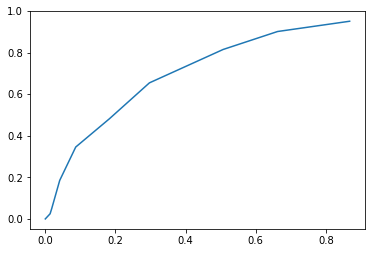

In [88]:
cut_offs = []
tpr = []
fpr = []
specics = []
for cut_off in np.linspace(0, 1, 22):
    #print(cut_off)
    test_pred2 = probs['Pos_2'].apply(lambda v: 2 if v > cut_off else 1)
    tn, fp, fn, tp = confusion_matrix(test_y, test_pred2, labels=[1,2]).ravel()
    sensitivity = (tp) / (tp + fn)
    specificity = (tn) / (tn + fp)
    cut_offs.append(cut_off)
    tpr.append(sensitivity)
    fpr.append(1-specificity)
    specics.append(specificity)
#print(cut_offs)
#print('------')
#print(tpr)
#print('------')
#print(fpr)
#import matplotlib.pyplot as plt
plt.plot(fpr, tpr)
#pd.DataFrame({'cut-off': cut_offs,
#             'sensitivity': tpr,
#             'specificity':specics})

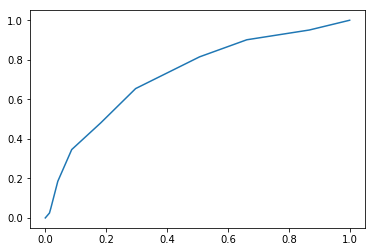

In [93]:
from sklearn.metrics import roc_curve
fpr, tpr, cutoffs = roc_curve(test_y, probs['Pos_2'], pos_label=2)
plt.plot(fpr, tpr)

In [102]:
df_roc = pd.DataFrame({
    'cutoff': cutoffs,
    'fpr': fpr,
    'tpr': tpr,
    'specificity': 1 - fpr
})
df_roc['youden_index'] = df_roc['tpr'] + df_roc['specificity'] - 1
df_roc.sort_values(by='youden_index', ascending=False).head(1)

,cutoff,fpr,tpr,specificity,youden_index
6,0.4,0.296804,0.654321,0.703196,0.357517


In [106]:
test_pred_new = probs['Pos_2'].apply(lambda v: 2 if v>0.4 else 1)

Random Forest AUC: 0.75
Adaboost AUC: 0.74
Decision Tree AUC: 0.65


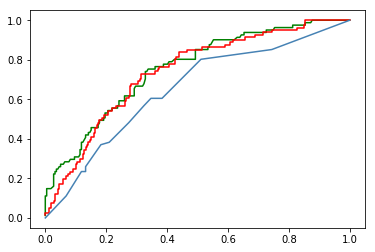

In [124]:
from sklearn.metrics import auc
model1 = RandomForestClassifier(random_state=100, n_estimators=1000)
model1.fit(train_x, train_y)
probs1 = pd.DataFrame(model1.predict_proba(test_x),
                      columns=['Neg_1', 'Pos_2'])

fpr, tpr, cutoffs = roc_curve(test_y, probs1['Pos_2'], pos_label=2)
auc_rf = auc(fpr, tpr)
plt.plot(fpr, tpr, color='green')

print('Random Forest AUC: %.2f' % auc_rf)
from sklearn.ensemble import AdaBoostClassifier
model2 = AdaBoostClassifier(random_state=100)
model2.fit(train_x, train_y)
probs2 = pd.DataFrame(model2.predict_proba(test_x),
                      columns=['Neg_1', 'Pos_2'])

fpr, tpr, cutoffs = roc_curve(test_y, probs2['Pos_2'], pos_label=2)
auc_ada = auc(fpr, tpr)
print('Adaboost AUC: %.2f' % auc_ada)
plt.plot(fpr, tpr, color='red')


model3 = DecisionTreeClassifier(max_depth=7, random_state=100)
model3.fit(train_x, train_y)
probs3 = pd.DataFrame(model3.predict_proba(test_x),
                      columns=['Neg_1', 'Pos_2'])

fpr, tpr, cutoffs = roc_curve(test_y, probs3['Pos_2'], pos_label=2)
plt.plot(fpr, tpr, color='steelblue')
auc_dt = auc(fpr, tpr)
print('Decision Tree AUC: %.2f' % auc_dt)